In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import pickle

In [2]:
# Load the dataset
data = pd.read_csv("Churn_Modelling.csv")  # Update with your actual file path

# Drop unnecessary columns
data.drop(["RowNumber", "CustomerId", "Surname"], axis=1, inplace=True)

# Convert categorical variables
data["Geography"] = LabelEncoder().fit_transform(data["Geography"])
data["Gender"] = LabelEncoder().fit_transform(data["Gender"])


In [3]:
# Feature Engineering: Identify High-Value Customers
data['HighValueCustomer'] = np.where(data['Balance'] > 100000, 1, 0)

# Split features and target
X = data.drop("Exited", axis=1)
y = data["Exited"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
# Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [5]:
# Scale the numerical features
scaler = StandardScaler()
X_train_sm = scaler.fit_transform(X_train_sm)
X_test = scaler.transform(X_test)


In [6]:
# Define models with reasonable parameters
best_gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
best_rf = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=42)
log_reg = LogisticRegression()


In [7]:
# Train models
best_gb.fit(X_train_sm, y_train_sm)
best_rf.fit(X_train_sm, y_train_sm)
log_reg.fit(X_train_sm, y_train_sm)

LogisticRegression()

In [8]:
# Predictions
y_pred_gb = best_gb.predict(X_test)
y_pred_rf = best_rf.predict(X_test)
y_pred_lr = log_reg.predict(X_test)

In [9]:
# Evaluate models
def evaluate_model(name, y_test, y_pred):
    print(f"\n{name} Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

evaluate_model("Gradient Boosting", y_test, y_pred_gb)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("Logistic Regression", y_test, y_pred_lr)



Gradient Boosting Performance:
Accuracy: 0.8205
ROC AUC Score: 0.7700827011595263
Confusion Matrix:
 [[1371  236]
 [ 123  270]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88      1607
           1       0.53      0.69      0.60       393

    accuracy                           0.82      2000
   macro avg       0.73      0.77      0.74      2000
weighted avg       0.84      0.82      0.83      2000


Random Forest Performance:
Accuracy: 0.806
ROC AUC Score: 0.7572151734380914
Confusion Matrix:
 [[1346  261]
 [ 127  266]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87      1607
           1       0.50      0.68      0.58       393

    accuracy                           0.81      2000
   macro avg       0.71      0.76      0.73      2000
weighted avg       0.83      0.81      0.82      2000


Logistic Regression Performance:
Accuracy: 0

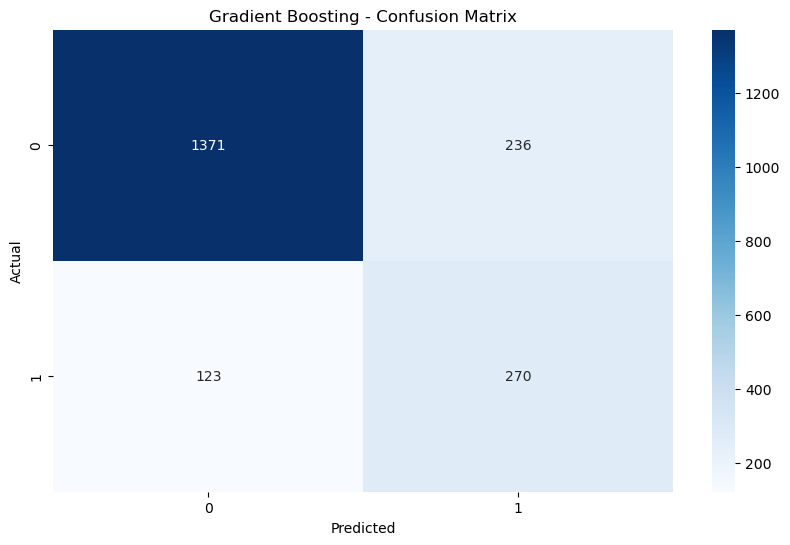

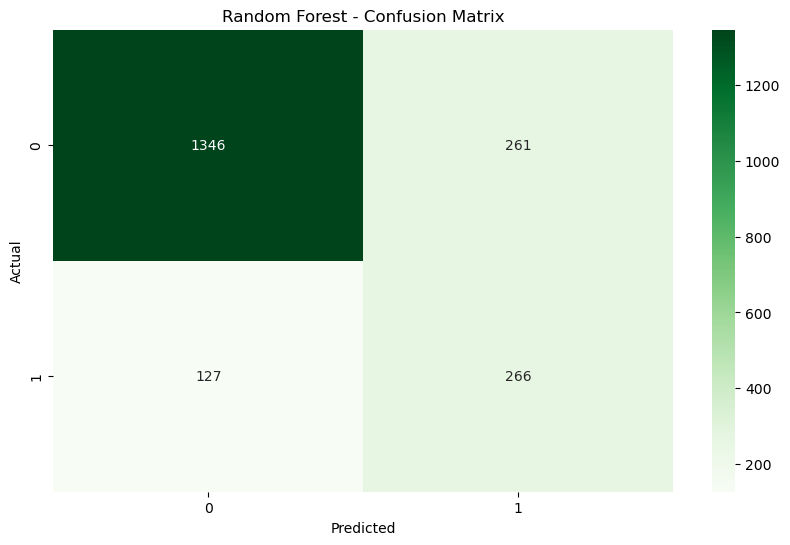

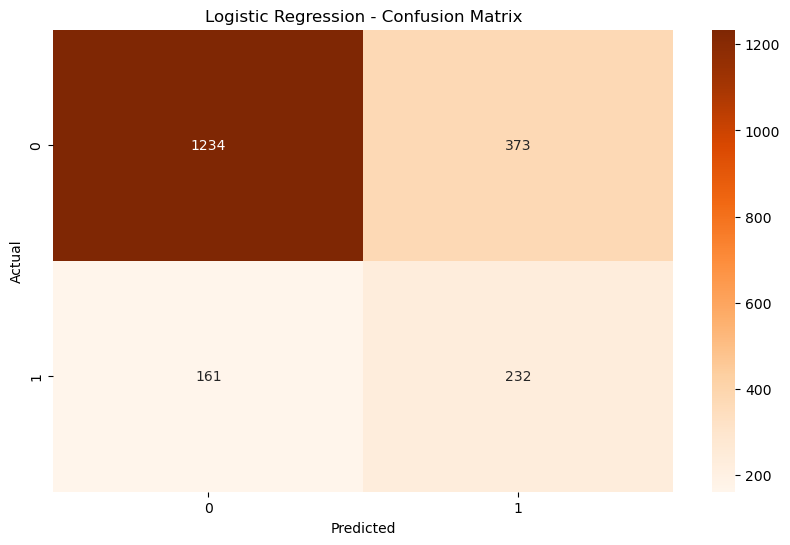

In [10]:
# Visualizations
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_gb), annot=True, fmt='d', cmap='Blues')
plt.title("Gradient Boosting - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Oranges')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


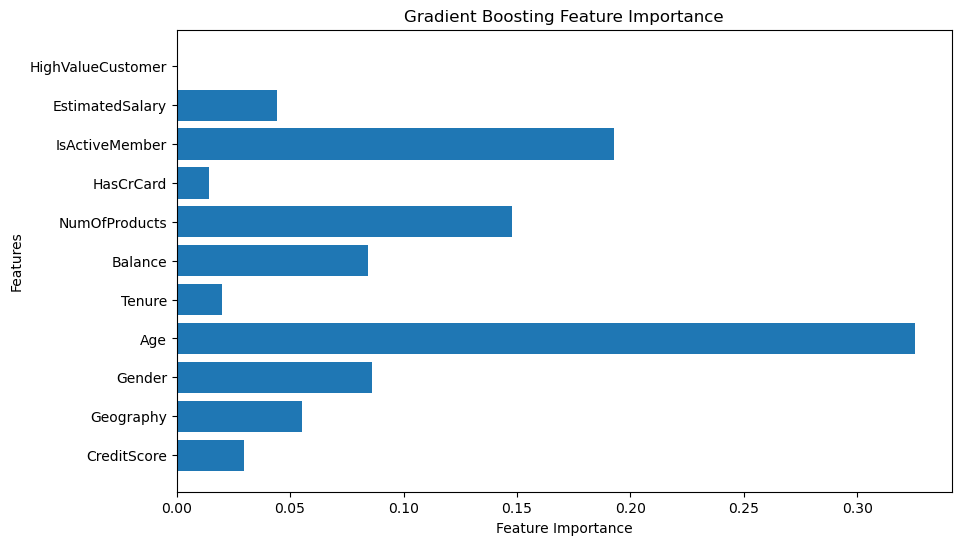

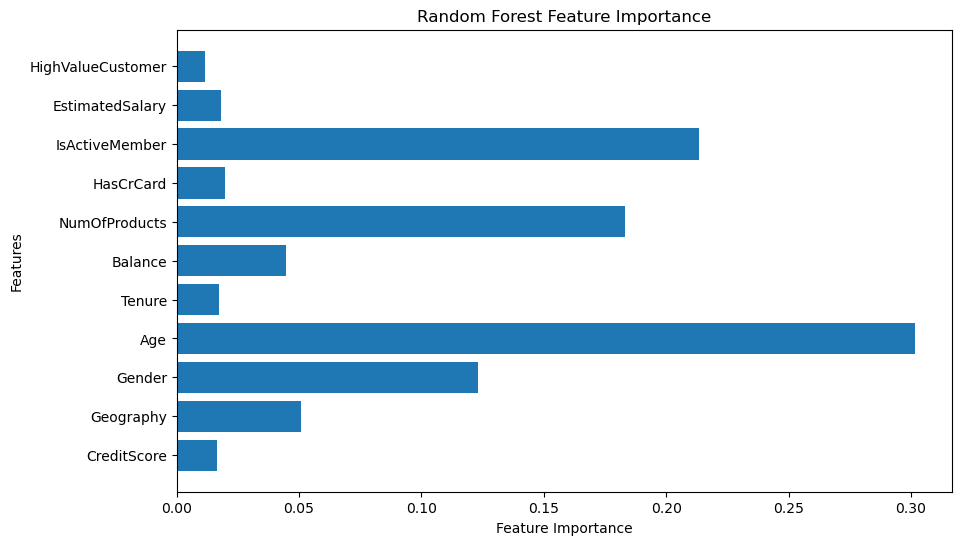

In [11]:
# Feature Importance Plots
plt.figure(figsize=(10, 6))
plt.barh(X.columns, best_gb.feature_importances_)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Gradient Boosting Feature Importance")
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(X.columns, best_rf.feature_importances_)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.show()


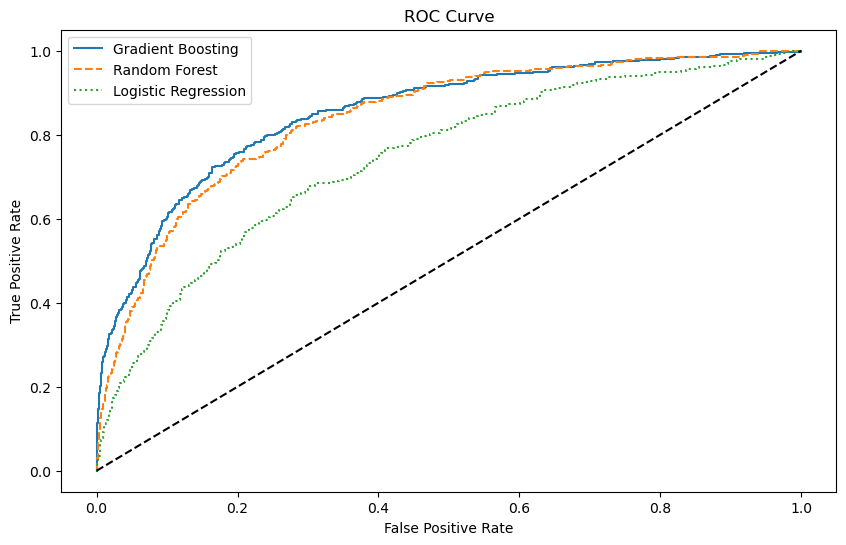

In [12]:
# ROC Curve
plt.figure(figsize=(10, 6))
fpr_gb, tpr_gb, _ = roc_curve(y_test, best_gb.predict_proba(X_test)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf.predict_proba(X_test)[:, 1])
fpr_lr, tpr_lr, _ = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
plt.plot(fpr_gb, tpr_gb, label="Gradient Boosting")
plt.plot(fpr_rf, tpr_rf, label="Random Forest", linestyle='dashed')
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression", linestyle='dotted')
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

C:\Users\Uma Mishra\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


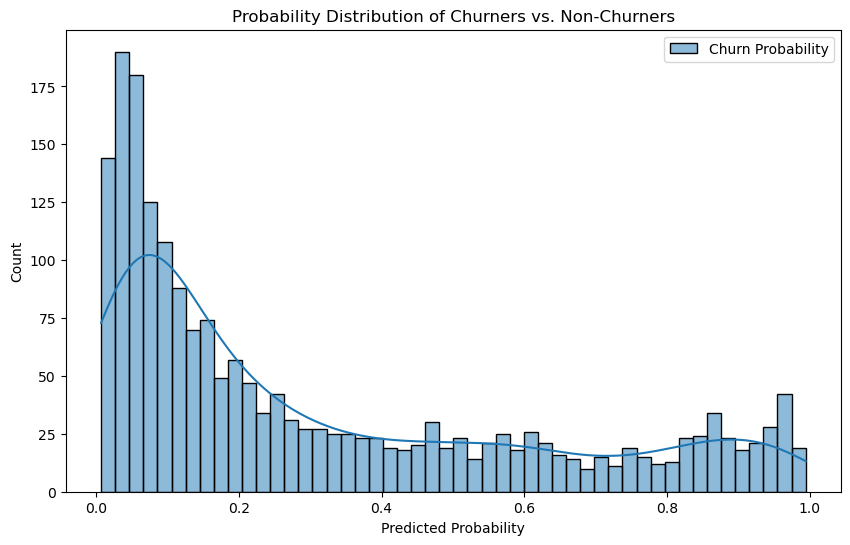

In [13]:
# Probability Distribution of Churners vs. Non-Churners
plt.figure(figsize=(10, 6))
sns.histplot(best_gb.predict_proba(X_test)[:, 1], bins=50, kde=True, label='Churn Probability')
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Probability Distribution of Churners vs. Non-Churners")
plt.legend()
plt.show()

In [14]:
# Save the best models
with open("best_gb_model.pkl", "wb") as file:
    pickle.dump(best_gb, file)

with open("best_rf_model.pkl", "wb") as file:
    pickle.dump(best_rf, file)

with open("best_lr_model.pkl", "wb") as file:
    pickle.dump(log_reg, file)
